# Preliminary operations

In [1]:
import os 

# SET HERE YOUR ROOTPATH
rootpath = 'C:\\Users\\chiar\\OneDrive\\Desktop\\XrAI'

# Set the working directory
os.chdir(rootpath) 

In [2]:
#@title Main libraries
import pandas as pd
import numpy as np

import os
import random

from sklearn.utils import  compute_class_weight

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow import keras
tfk = tf.keras
tfkl = tf.keras.layers

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
#@title Reproducibility
# Setting a seed for reproducibility
seed = 90 
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("The seed is: " + str(seed))

The seed is: 90


# Data access

In [4]:
def get_next_batch(generator, image_index=0): #function to take one batch from generator, to take an image we consider first element of the batch
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)


  # Visualize only the first sample
  image = image[image_index]
  target = target[image_index]
  target_idx = np.argmax(target)
  
  idx = (generator.batch_index -1) * generator.batch_size
  print(generator.filenames[idx : idx + generator.batch_size][image_index])
  
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  image_2_show = image[:,:,0]
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.double(image_2_show),cmap='gray')

  return batch, image_2_show, target


def get_next_image(generator):
  #restituisce un immagine su tre canali, i pixel sono nel range 0-1
  im = next(generator)
  im = im[0]
  im = im[0,:,:,:]#/np.amax(im)
  return im


def visualize_images(batch):
  # generator.next() provides [images, labels] (with dimension batch_size)

  images = batch[0]
  dim = images.shape
  dim = dim[0]
  size,scale = 224, 10
  c=8
    
  for i in range(int(dim/c)):
    f, axs = plt.subplots(1,c, figsize=(20,20))
    axs.flat
    xs = images[i*c:i*c+c]
    for j in range(c):
      img = xs[j]
      axs[j].imshow(img/255)
      


# Generators creation

In [5]:
# pixels ranging 0-255
def get_bg_angle(bkgr, angle):
  for _, row in enumerate(angle):
    for _, pix in enumerate(row):
      if pix<255*0.2:
        bkgr.append(0)
      elif pix>255*0.8:
        bkgr.append(1)
  return bkgr

def is_inverted(im):
  #input is a 224x224 image on 3 channels (224,224,3)
  #pixels should range in 0-255
  top_left = im[0:5,0:5,0]
  top_right = im[0:5,-5:225,0]
  bottom_left = im[-5:225, 0:5,0]
  bottom_right = im[-5:225,-5:225,0]

  background = []
  for _,ang in enumerate([top_left, top_right, bottom_left, bottom_right]):
    background = get_bg_angle(background, ang)

  if sum(background) < 0.5*len(background):
    inv = 0
  else: 
    inv = 1
  return inv

def invert(im):
  if is_inverted(im):
    return 255-im
  else:
    return im

# Preprocessing
## Adding Gaussian noise

In [6]:
def add_noise(im, noise_amount = 0.3):
  noise_factor = noise_amount*255
  im_n = im[:,:,0] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=im[:,:,0].shape) 
  for i, row in enumerate(im_n):
    for j, pix in enumerate(row):
      if pix<0:
        im_n[i,j]=0
      elif pix>255:
        im_n[i,j]=255

  #im_n = im_n - np.amin(im_n) #
  #im_n = (im_n/np.amax(im_n))*255 #queste due righe servono per ricentrare i pixel

  im_n3 = np.stack((im_n, im_n, im_n), axis=2)

  return im_n3

In [7]:
def invert_and_noise(im):
  im = invert(im)
  im = add_noise(im)
  return im

## Reversing images

In [8]:
def add_reversion(im):
    '''Black pixels become white and vice versa'''
    im_n = im[:,:,0]
    im_n = 255 - im_n
    im_n3 = np.stack((im_n, im_n, im_n), axis=2)
    return im_n3

## Adding salt and pepper noise

In [9]:
#@title Preprocessing: adding salt and pepper noise
def add_salt_pepper(im, noise_amount=0.1):
    '''Add salt and pepper noise to image'''
    
    # make a copy of the image
    im_n = im[:,:,0]

    # the threshold for the random number to be less than or greater than
    rdn_threshold = noise_amount

    # for each pixel in the image, there is a noise_amount chance that it will be replaced with 0 or 255
    for i, row in enumerate(im_n):
        # for each pixel in the row
        for j, pix in enumerate(row):
            # i is the row index, j is the column index
            rdn = np.random.normal(loc=0.5, scale = 0.1)
            
            if rdn < rdn_threshold:
                im_n[i,j] = 0
            elif rdn > 1-rdn_threshold:
                im_n[i,j] = 255
    im_n3 = np.stack((im_n, im_n, im_n), axis=2)
    return im_n3

In [11]:
#@title Data parameters
data_hyperparameters = {
    'batch_size': 32,
    'resized_shape_height': 224,
    'resized_shape_width': 224,
    'color_mode': 'rgb'
}

n_channels = 1 if data_hyperparameters['color_mode']=='grayscale' else 3
input_shape = (data_hyperparameters['resized_shape_height'],data_hyperparameters['resized_shape_width'],n_channels) 

In [12]:
#@title Create data generator: both with and without inversion check
train_dir = os.path.join("splitted_dataset","train")
validation_dir = os.path.join("splitted_dataset","val")

dg1=ImageDataGenerator()
train_set = dg1.flow_from_directory(directory = train_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)
dg2= ImageDataGenerator(preprocessing_function=invert)
train_set_inv = dg2.flow_from_directory(directory = train_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)

dg3 =  ImageDataGenerator(preprocessing_function=invert_and_noise)
train_set_noise =dg3.flow_from_directory(directory = train_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)

validation_set = ImageDataGenerator().flow_from_directory(directory = validation_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)

validation_set_inv = ImageDataGenerator(preprocessing_function=invert).flow_from_directory(directory = validation_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)

validation_set_noise = ImageDataGenerator(preprocessing_function=invert_and_noise).flow_from_directory(directory = validation_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)

Found 11129 images belonging to 3 classes.
Found 11129 images belonging to 3 classes.
Found 11129 images belonging to 3 classes.
Found 1246 images belonging to 3 classes.
Found 1246 images belonging to 3 classes.
Found 1246 images belonging to 3 classes.


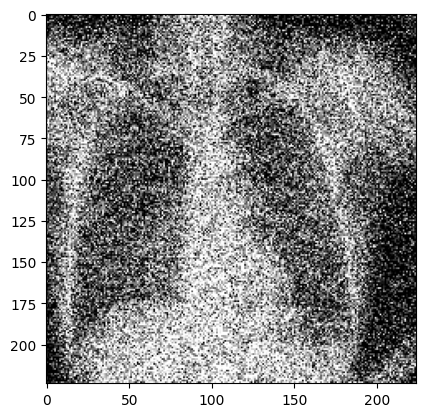

In [13]:
b = train_set.next()
b = b[0]
b= b[0,:,:,:]
plt.imshow(b/255)

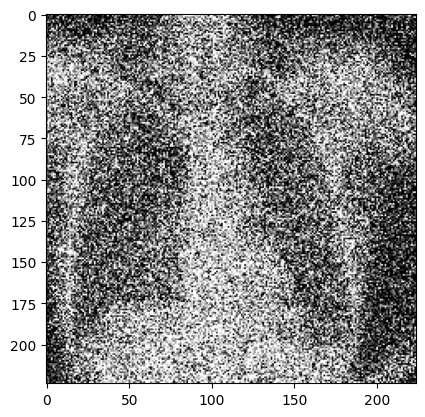

In [14]:
b = train_set_noise.next()
b = b[0]
b= b[0,:,:,:]
plt.imshow(b/255)

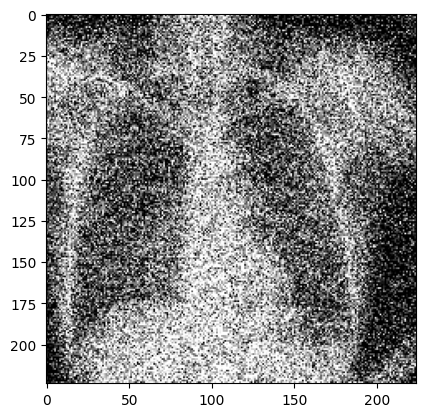

In [15]:
b = train_set_inv.next()
b = b[0]
b= b[0,:,:,:]
plt.imshow(b/255)

Now look at the results on a batch

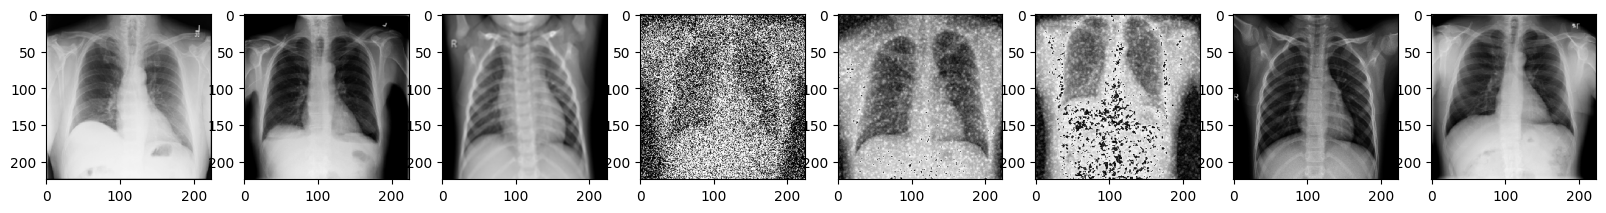

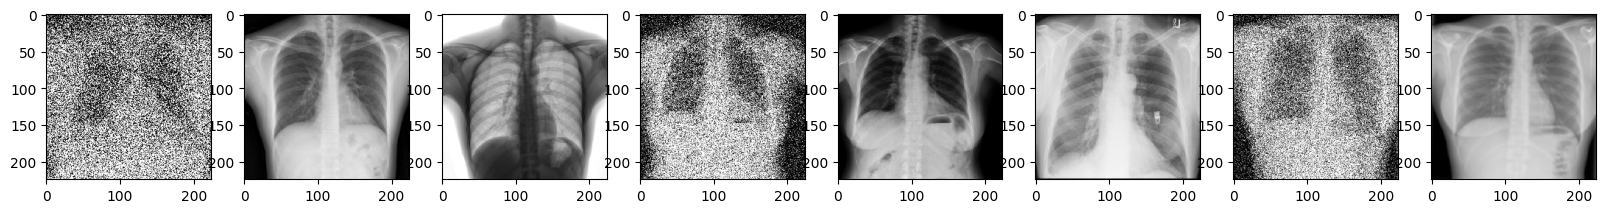

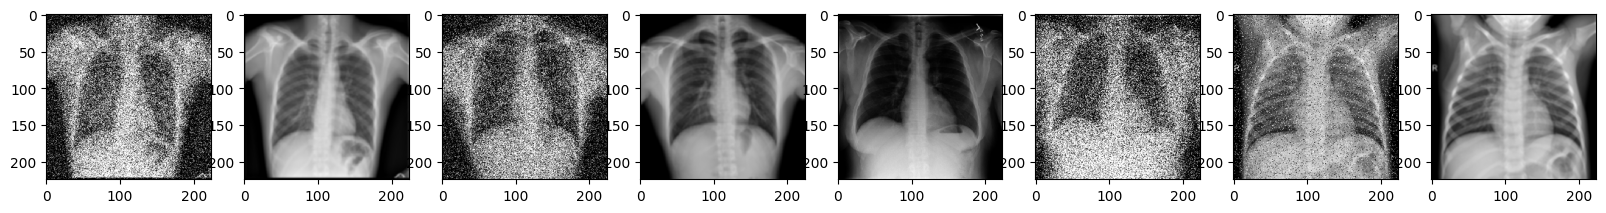

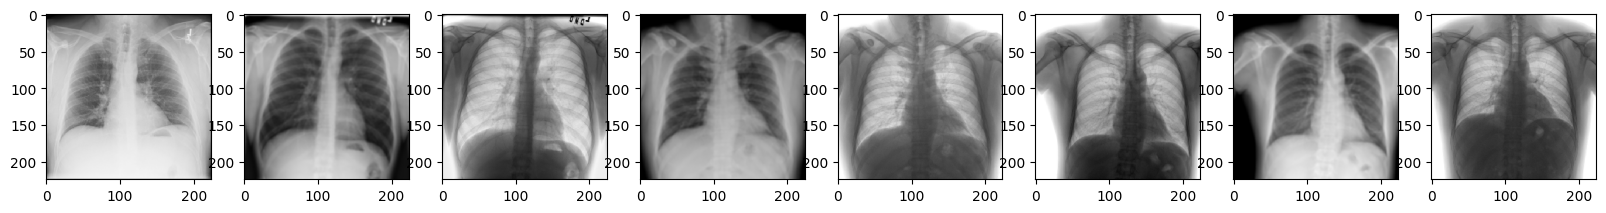

In [16]:
visualize_images(train_set.next())

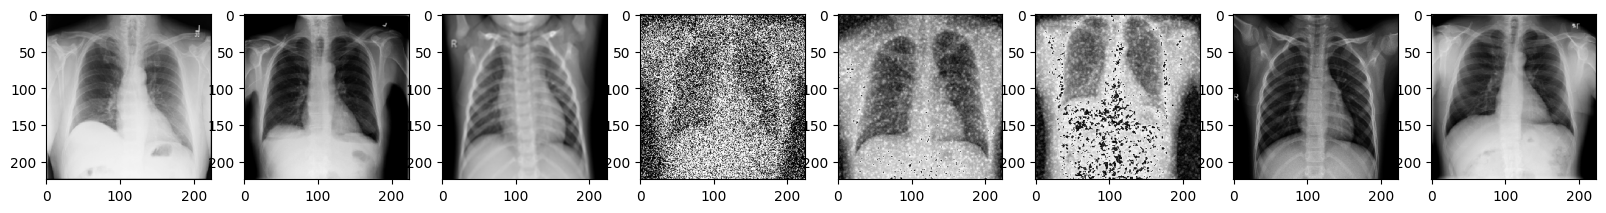

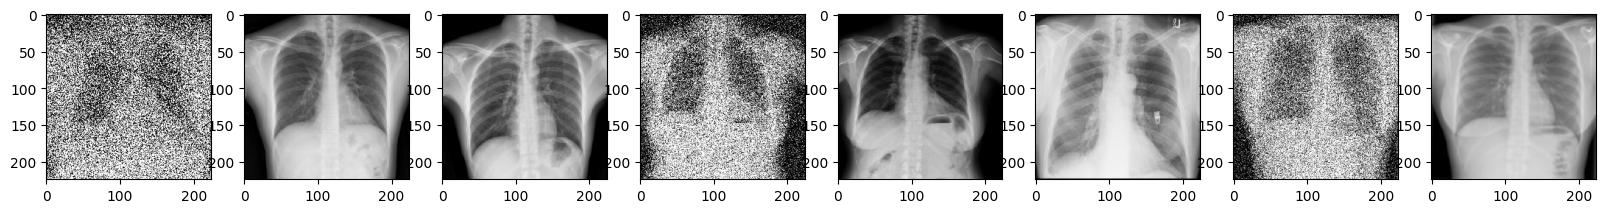

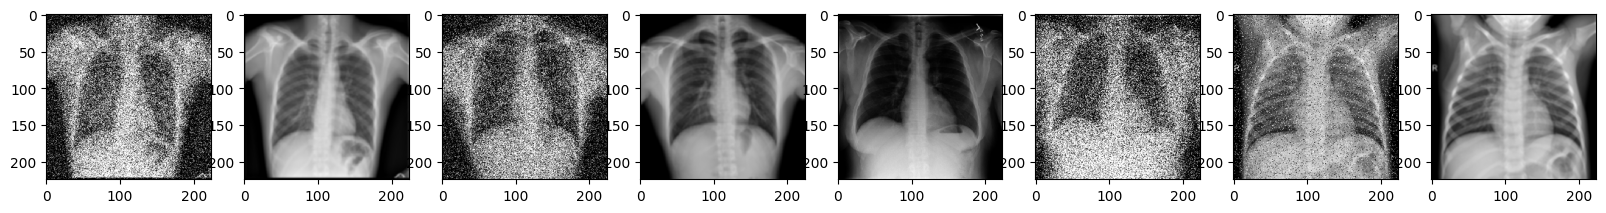

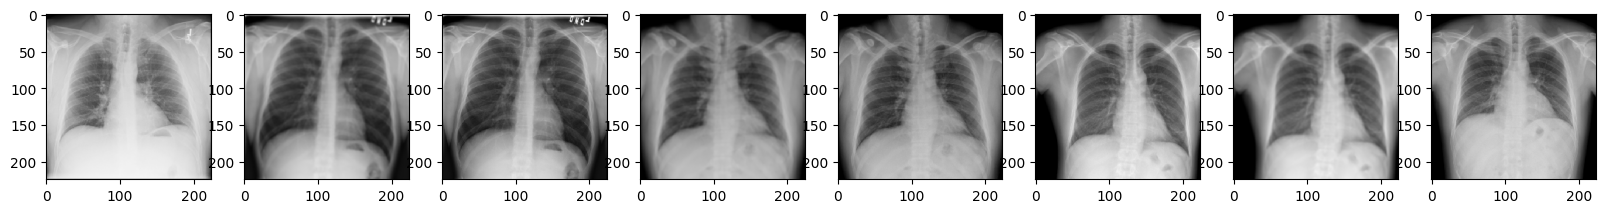

In [17]:
visualize_images(train_set_inv.next())

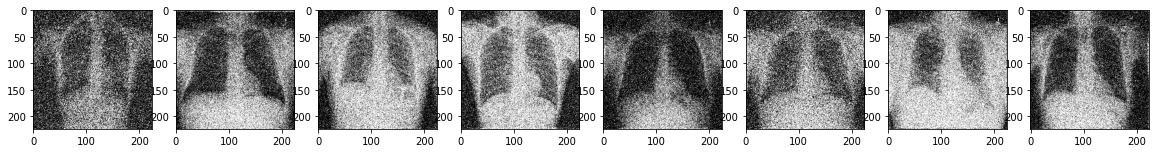

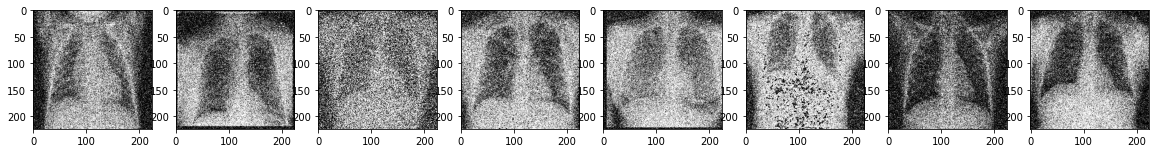

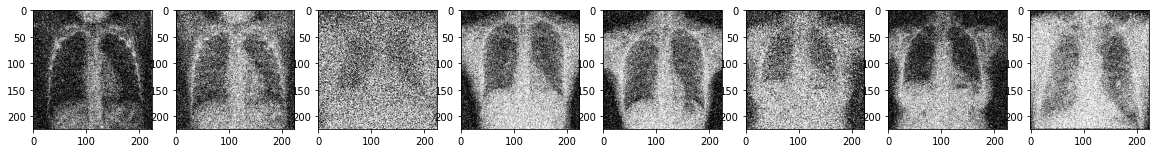

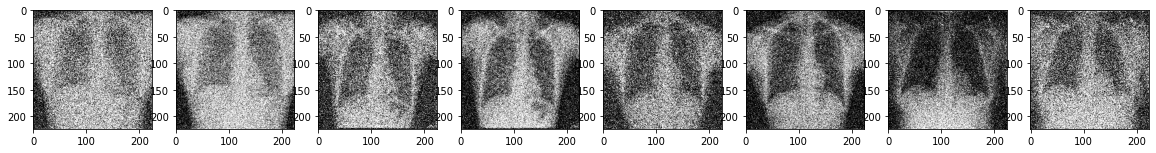

In [18]:
visualize_images(train_set_noise.next())

# Create a generator that can apply to images three kind of noise but also no noise at all:
- Salt & Pepper
- Gaussian
- Inversion
- Nothing

In [18]:
def make_image_noisy(im):
  '''
  This function randomly applies one of the three noise functions
  Input: image
  Output: noisy image
  '''
  switch = np.random.randint(0,4)
  # 0: no noise
  if switch==1:
    # 1: reversion
    im=add_reversion(im)
  elif switch==2:
    # 2: salt and pepper
    im=add_salt_pepper(im, 0.3)
  elif switch==3:
    # 3: Gaussian
    im=add_noise(im, 0.2)

  return im

In [19]:
train_dir = os.path.join("splitted_dataset","train")
validation_dir = os.path.join("splitted_dataset","val")

# FIXME: select as directories the ones that contain clean images
dg_pure=ImageDataGenerator()
train_set = dg_pure.flow_from_directory(directory = train_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)

dg_noisy= ImageDataGenerator(preprocessing_function=make_image_noisy)
train_set_noisy = dg_noisy.flow_from_directory(directory = train_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)


Found 11129 images belonging to 3 classes.
Found 11129 images belonging to 3 classes.


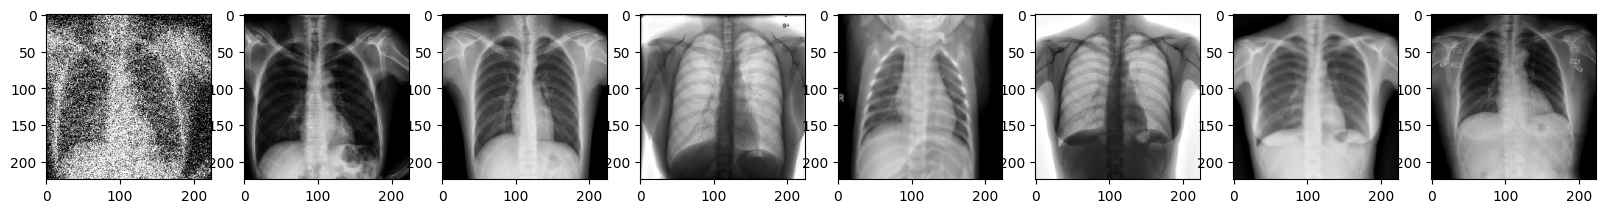

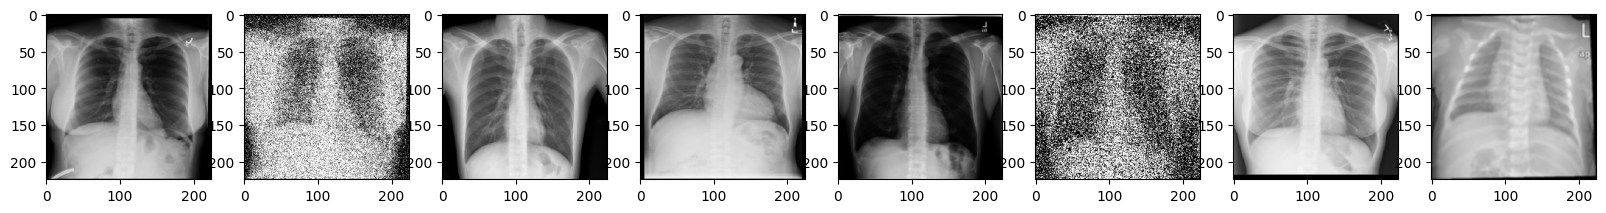

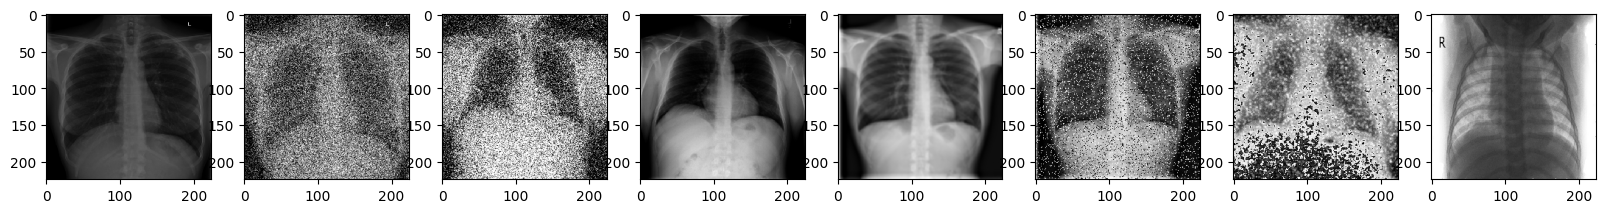

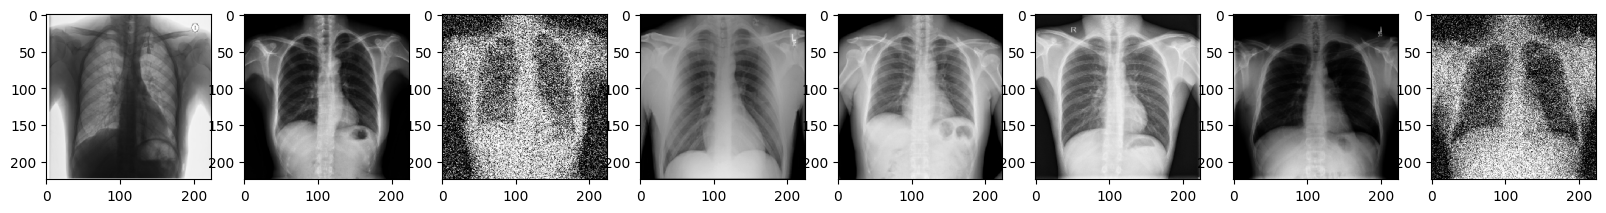

In [20]:
visualize_images(train_set.next())

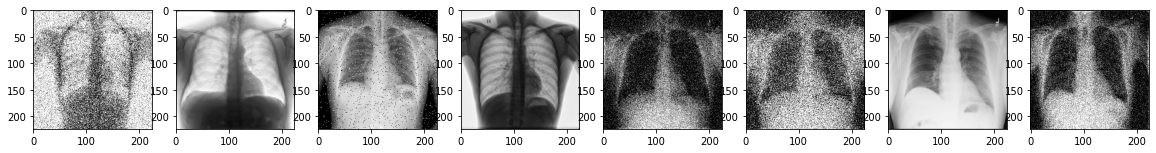

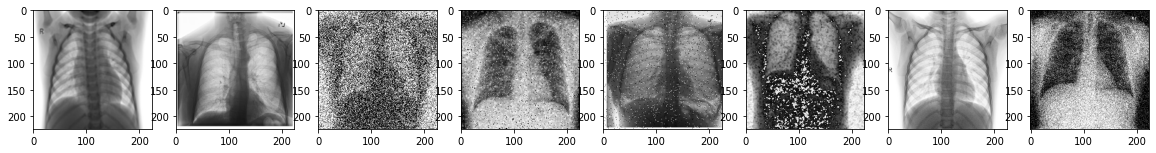

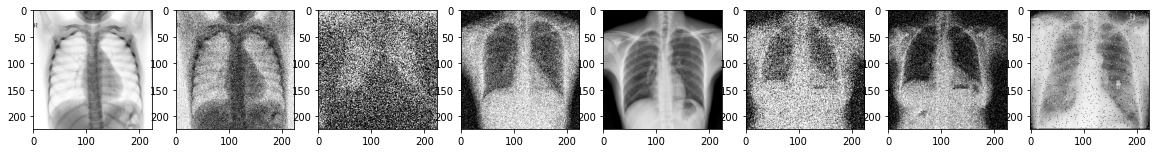

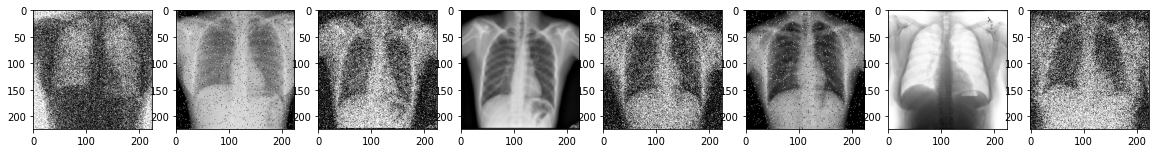

In [141]:
visualize_images(train_set_noisy.next())

# 